In [1]:
import numpy as np
from matplotlib import pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

In [5]:
data_set_directory = '../input/10-monkey-species'
training_path = data_set_directory + '/training/training'
validation_path = data_set_directory + '/validation/validation'

In [6]:
image_size = (224, 224)
batch_size = 64

train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    training_path,
    label_mode = 'int',
    seed = 1337,
    image_size=image_size,
    batch_size=batch_size,
)
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    validation_path,
    label_mode = 'int',
    seed =1337,
    image_size=image_size,
    batch_size=batch_size,
)

Found 1097 files belonging to 10 classes.
Found 272 files belonging to 10 classes.


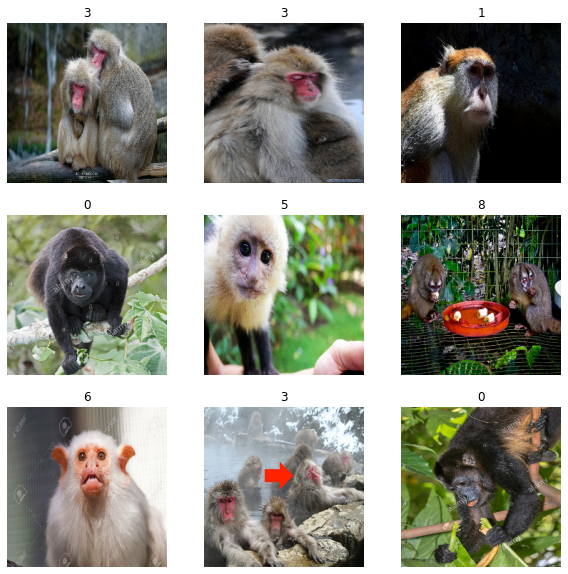

In [7]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(int(labels[i]))
        plt.axis("off")

In [8]:
# Data Augmentation Layer for training

data_augmentation_train = keras.Sequential(
    [
        layers.experimental.preprocessing.RandomFlip("horizontal"),
        layers.experimental.preprocessing.RandomRotation(0.1),
        layers.experimental.preprocessing.Rescaling(scale =1./255),
        layers.experimental.preprocessing.RandomHeight(0.1),
        layers.experimental.preprocessing.RandomWidth(0.1)
     
    ]
)

In [9]:
# Data Augmentation Layer for testing

data_augmentation_test = keras.Sequential(
    [
        layers.experimental.preprocessing.Rescaling(scale =1./255)
     
    ]
)

In [10]:
# Map the Data now

augmented_train_ds = train_ds.map(
  lambda x, y: (data_augmentation_train(x, training=True), y))

augmented_val_ds = val_ds.map(
  lambda x, y: (data_augmentation_test(x, training=True), y))

In [11]:
from tensorflow.keras.applications.inception_v3 import InceptionV3

pre_trained_model = InceptionV3(input_shape=(224,224,3),
                                               include_top=False,
                                               weights='imagenet')

for layer in pre_trained_model.layers:
    layer.trainable = False

87916544/87910968 [==============================] - 2s 0us/step


In [12]:
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
from keras.optimizers import Adam
from keras import regularizers

global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
Dl_1 = tf.keras.layers.Dropout(rate = 0.2)
prediction_layer = tf.keras.layers.Dense(120,activation='softmax')

model_V3 = tf.keras.Sequential([
    pre_trained_model,
    global_average_layer,
    Dl_1,
    prediction_layer
])

model_V3.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [13]:
# Callbacks

lr_reduce = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, verbose=2, mode='max')
early_stop = EarlyStopping(monitor='val_loss', min_delta=0.1, patience=1, mode='min')

In [14]:
tf.keras.backend.clear_session()

In [15]:
history = model_V3.fit(
           augmented_train_ds, 
           epochs=30, validation_data=augmented_val_ds, callbacks=[lr_reduce])

Epoch 1/30
18/18 [==============================] - 31s 2s/step - loss: 1.9480 - accuracy: 0.4667 - val_loss: 0.4329 - val_accuracy: 0.9412
Epoch 2/30
18/18 [==============================] - 21s 1s/step - loss: 0.3997 - accuracy: 0.9052 - val_loss: 0.2132 - val_accuracy: 0.9559
Epoch 3/30
18/18 [==============================] - 20s 1s/step - loss: 0.2399 - accuracy: 0.9335 - val_loss: 0.1649 - val_accuracy: 0.9559
Epoch 4/30
18/18 [==============================] - ETA: 0s - loss: 0.1811 - accuracy: 0.9517
Epoch 00004: ReduceLROnPlateau reducing learning rate to 0.00020000000949949026.
18/18 [==============================] - 20s 1s/step - loss: 0.1811 - accuracy: 0.9517 - val_loss: 0.1487 - val_accuracy: 0.9632
Epoch 5/30
18/18 [==============================] - 19s 1s/step - loss: 0.1611 - accuracy: 0.9599 - val_loss: 0.1416 - val_accuracy: 0.9669
Epoch 6/30
18/18 [==============================] - 20s 1s/step - loss: 0.1570 - accuracy: 0.9553 - val_loss: 0.1399 - val_accuracy: 0.9

In [16]:
model_V3.save('monkey_classification96_69valacc.h5')

__notebook_source__.ipynb  monkey_classification96_69valacc.h5
